In [19]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
# import chain

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

from os.path import isfile, join

asdf

In [20]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)

asdf

In [21]:
class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points):
        # print(props)
        self.size = [18, 6]
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points

        self.color_pool = ['blue', 'red', 'orange', 'green']

    def show(self):
        plt.rcParams['figure.figsize'] = (self.size[0], self.size[1])
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.grid()
        
        print("data to graph: ", self.data_to_graph)

        for i in range(len(self.data_to_graph) - 0):
            if self.type == "semilogy":
                plt.semilogy(self.data_to_graph[i][0], self.data_to_graph[i][1], color=self.color_pool[i])
            elif self.type == "plot":
                plt.plot(self.data_to_graph[i][0], self.data_to_graph[i][1], color=self.color_pool[i])
                
        for i in range(len(self.hlines)):
            plt.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

        for i in range(len(self.points)):
            plt.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=self.color_pool[i], markerfacecolor=self.color_pool[i])
        
        plt.savefig('figures/' + self.title[:20] + '.png', bbox_inches='tight')
        plt.figure(get_rand_id())
        plt.show()

asdf

In [22]:
# this will take a file name
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []
        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_all_data_into_IV_curves()
        self.sort_data_into_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/NbO2-Fall-23/summerData/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):
        # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
        rows_to_exclude = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
        data = rows_to_exclude.values
        rows_to_exclude.head()
        I_to_skip = data[:,1]
        # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
        self.max_current = np.max(I_to_skip) * 0.9999999
        print("max current: ", self.max_current)
        over_max_current_indexes = ((I_to_skip > self.max_current).nonzero())[0]


        # read the file again without the rows that have a current above the threshold
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)
        
        # self.time = data[:,0]
        # interval = average(np.gradient(data[:,0][10:15]))
        interval = 1
        self.time = np.arange(0, len(data[:,0])) * interval

        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        self.R = self.V / self.I
        self.R = np.abs(self.R)

    def graph_all_data(self):
        the_graph = Graph(
            "All Data",         # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [self.max_current], # hlines
            "semilogy",         # type of graph
            [[self.V, self.I]],   # data to graph
            [],                 # points
        )
        the_graph.show()

    def break_all_data_into_IV_curves(self):
        # get the index of every "0" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the frist and last 4 reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        self.IV_curves = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2))

            dI = np.gradient(self.I[start:stop])
            ddI = np.gradient(np.gradient(self.I[start:stop]))
            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.temps[start:stop])
            self.IV_curves.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'R': self.R[start:stop],
                'dI': dI,
                'ddI': ddI,
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
                'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
                'max_ddI': np.argmax(ddI),
            })

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2))
            stop = self.all_zero_indexes[i+1]

            dI = np.gradient(self.I[start:stop])
            ddI = np.gradient(np.gradient(self.I[start:stop]))
            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.temps[start:stop])
            self.IV_curves.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'R': self.R[start:stop],
                'dI': dI,
                'ddI': ddI,
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
                'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
                'max_ddI': np.argmax(ddI),
            })

        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1
        print("number of IV curves: ", self.number_of_IV_curves)

    def sort_data_into_types(self):
        pos_thresh_IV_curve_count = 0
        pos_hold_IV_curve_count = 0
        neg_thresh_IV_curve_count = 0
        neg_hold_IV_curve_count = 0

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                pos_thresh_IV_curve_count += 1

            if IV_curve['type_of_data'] == "negThresh":
                neg_thresh_IV_curve_count += 1

            if IV_curve['type_of_data'] == "posHold":
                pos_hold_IV_curve_count += 1

            if IV_curve['type_of_data'] == "negHold":
                neg_hold_IV_curve_count += 1

        print("pos_thresh_IV_curve_count: ", pos_thresh_IV_curve_count)
        print("pos_hold_IV_curve_count: ", pos_hold_IV_curve_count)
        print("neg_thresh_IV_curve_count: ", neg_thresh_IV_curve_count)
        print("neg_hold_IV_curve_count: ", neg_hold_IV_curve_count)

    def graph_IV_curve(self, index):
        title_time = "  Time =" + str(round(self.IV_curves[index]['time'][0])) + " s"
        title_temp = "  Temp =" + str(round(self.IV_curves[index]['temp'])) + " K" + " Std: " + str(round(self.IV_curves[index]['temp_std'], 3))
        title = "IV curve # " + str(index) + title_time + title_temp

        data_to_graph = []
        points_to_graph = []

        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

        the_graph = Graph(
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
        )
        the_graph.show()


    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)


    def graph_IV_curves_at_temp(self, start, stop):
        for i in range(0, len(self.IV_curves) - 1, 4):
            temp = self.IV_curves[i]['temp']
            if temp > start and temp < stop: 
                self.graph_IV_curve(i)

    def graph_voltage_vs_temp_type(self, type_of_data):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(temp)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(temp)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(temp)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(temp)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Temperature",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )
        the_graph.show()


    def graph_voltage_vs_resistance(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(resistance)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(resistance)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(resistance)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(resistance)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Resistance",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )
        the_graph.show()


    def graph_voltage_vs_temp(self):
        xAxis_posThresh = []
        yAxis_posThresh = []

        xAxis_negThresh = []
        yAxis_negThresh = []

        xAxis_posHold = []
        yAxis_posHold = []

        xAxis_negHold = []
        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            temp = IV_curve['temp']
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                xAxis_posThresh.append(temp)
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                xAxis_negThresh.append(temp)
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                xAxis_posHold.append(temp)
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                xAxis_negHold.append(temp)
                yAxis_negHold.append(current)

        data_to_graph = [
            [xAxis_posThresh, yAxis_posThresh],
            [xAxis_negThresh, yAxis_negThresh],
            [xAxis_posHold, yAxis_posHold],
            [xAxis_negHold, yAxis_negHold],
            ]

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Temp",   # title
            "Temp (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )
        the_graph.show()

    def graph_resistance_vs_temp(self, voltage_to_plot, type_of_data):

        data_to_graph = [[], []]

        data_to_graph[0] = []
        data_to_graph[1] = []

        for i in range(2, len(self.V) - 2):
            voltageAtPoint = abs(self.V[i])
            if voltageAtPoint > voltage_to_plot * 0.96 and voltageAtPoint < voltage_to_plot * 1.04 and sort_into_side(self.V[i-3:i+3], self.I[i-3:i+3]) == type_of_data:
                # print()
                data_to_graph[0].append(self.temps[i])
                data_to_graph[1].append(self.R[i])

        the_graph = Graph(
            type_of_data + " Resistance vs Temp at " + str(voltage_to_plot) + " V",   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "semilogy",                             # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )
        the_graph.show()

    def graph_resistance_vs_temp_123(self):

        oneOverTemp = []
        for temp in self.temps:
            oneOverTemp.append(1 / temp)
        data_to_graph = [oneOverTemp, self.R]
        the_graph = Graph(
            "Log R vs 1/T",   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "semilogy",                             # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )
        the_graph.show()

asdf

max current:  0.0010000508999949002
number of data points:  20399
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_hold_IV_curve_count:  46
data to graph:  [[array([nan, 0.0, 0.0085, ..., -1.649, -1.666, -1.683], dtype=object), array([nan, 1.20007e-10, 3.138605e-08, ..., 0.001000021, 0.001000021,
       0.0009999641], dtype=object)]]


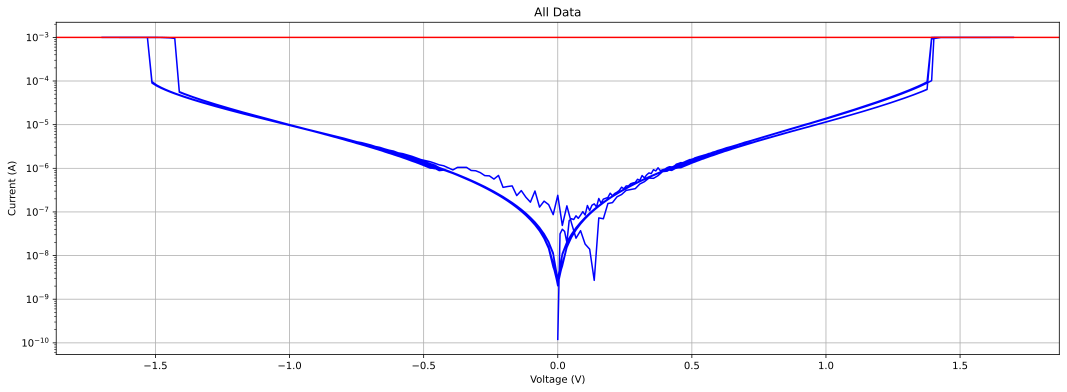

<Figure size 1800x600 with 0 Axes>

data to graph:  [[array([0.0, 0.017, 0.034, 0.051, 0.068, 0.085, 0.102, 0.119, 0.136, 0.153,
       0.17, 0.187, 0.204, 0.221, 0.238, 0.255, 0.272, 0.289, 0.306,
       0.323, 0.34, 0.357, 0.374, 0.391, 0.408, 0.425, 0.442, 0.459,
       0.476, 0.493, 0.51, 0.527, 0.544, 0.561, 0.578, 0.595, 0.612,
       0.629, 0.646, 0.663, 0.68, 0.697, 0.714, 0.731, 0.748, 0.765,
       0.782, 0.799, 0.816, 0.833, 0.85, 0.867, 0.884, 0.901, 0.918,
       0.935, 0.952, 0.969, 0.986, 1.003, 1.02, 1.037, 1.054, 1.071,
       1.088, 1.105, 1.122, 1.139, 1.156, 1.173, 1.19, 1.207, 1.224,
       1.241, 1.258, 1.275, 1.292, 1.309, 1.326, 1.343, 1.36, 1.377,
       1.394, 1.411, 1.428, 1.445, 1.462, 1.479, 1.496, 1.513, 1.53,
       1.547, 1.564, 1.581, 1.598, 1.615, 1.632, 1.649, 1.666, 1.683],
      dtype=object), array([2.118348e-09, 1.071969e-08, 1.992571e-08, 3.087415e-08,
       4.349142e-08, 5.811809e-08, 7.503362e-08, 9.429908e-08,
       1.162086e-07, 1.405032e-07, 1.679632e-07, 1.980572e-07,
     

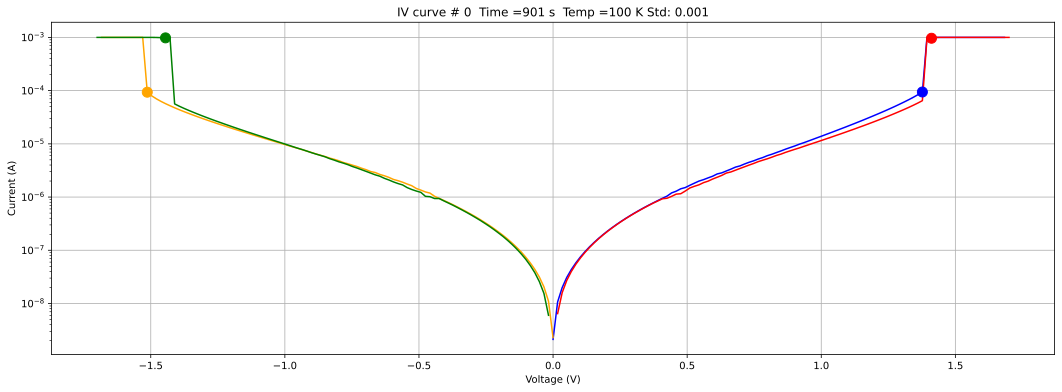

<Figure size 1800x600 with 0 Axes>

data to graph:  [[array([0.0, 0.017, 0.034, 0.051, 0.068, 0.085, 0.102, 0.119, 0.136, 0.153,
       0.17, 0.187, 0.204, 0.221, 0.238, 0.255, 0.272, 0.289, 0.306,
       0.323, 0.34, 0.357, 0.374, 0.391, 0.408, 0.425, 0.442, 0.459,
       0.476, 0.493, 0.51, 0.527, 0.544, 0.561, 0.578, 0.595, 0.612,
       0.629, 0.646, 0.663, 0.68, 0.697, 0.714, 0.731, 0.748, 0.765,
       0.782, 0.799, 0.816, 0.833, 0.85, 0.867, 0.884, 0.901, 0.918,
       0.935, 0.952, 0.969, 0.986, 1.003, 1.02, 1.037, 1.054, 1.071,
       1.088, 1.105, 1.122, 1.139, 1.156, 1.173, 1.19, 1.207, 1.224,
       1.241, 1.258, 1.275, 1.292, 1.309, 1.326, 1.343, 1.36, 1.377,
       1.394, 1.411, 1.428, 1.445, 1.462, 1.479, 1.496, 1.513, 1.53,
       1.547, 1.564, 1.581, 1.598, 1.615, 1.632, 1.649, 1.666, 1.683],
      dtype=object), array([2.149687e-09, 1.05393e-08, 1.971468e-08, 3.014538e-08,
       4.274379e-08, 5.696124e-08, 7.343321e-08, 9.245699e-08,
       1.13911e-07, 1.380459e-07, 1.652804e-07, 1.952234e-07,
       

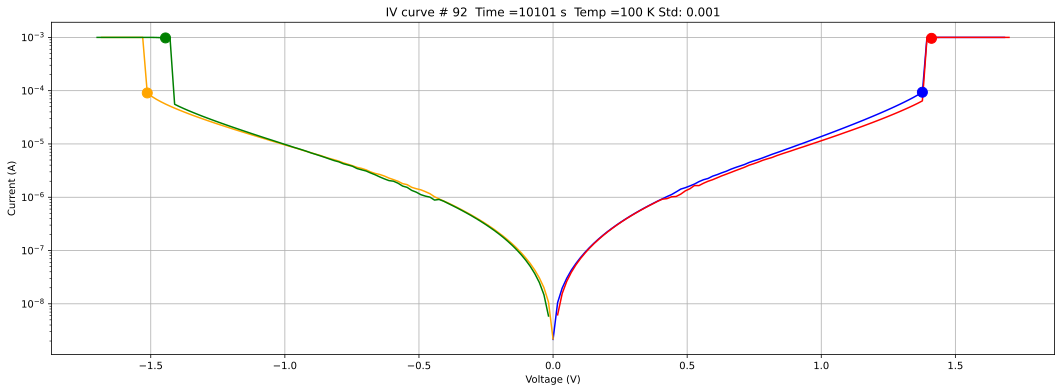

<Figure size 1800x600 with 0 Axes>

data to graph:  [[array([0.0, -0.017, -0.034, -0.051, -0.068, -0.085, -0.102, -0.119,
       -0.136, -0.153, -0.17, -0.187, -0.204, -0.221, -0.238, -0.255,
       -0.272, -0.289, -0.306, -0.323, -0.34, -0.357, -0.374, -0.391,
       -0.408, -0.425, -0.442, -0.459, -0.476, -0.493, -0.51, -0.527,
       -0.544, -0.561, -0.578, -0.595, -0.612, -0.629, -0.646, -0.663,
       -0.68, -0.697, -0.714, -0.731, -0.748, -0.765, -0.782, -0.799,
       -0.816, -0.833, -0.85, -0.867, -0.884, -0.901, -0.918, -0.935,
       -0.952, -0.969, -0.986, -1.003, -1.02, -1.037, -1.054, -1.071,
       -1.088, -1.105, -1.122, -1.139, -1.156, -1.173, -1.19, -1.207,
       -1.224, -1.241, -1.258, -1.275, -1.292, -1.309, -1.326, -1.343,
       -1.36, -1.377, -1.394, -1.411, -1.428, -1.445, -1.462, -1.479,
       -1.496, -1.513, -1.53, -1.547, -1.564, -1.581, -1.598, -1.615,
       -1.632, -1.649, -1.666, -1.683], dtype=object), array([2.288219e-09, 1.087625e-08, 2.047847e-08, 3.115695e-08,
       4.36434e-08, 5.77

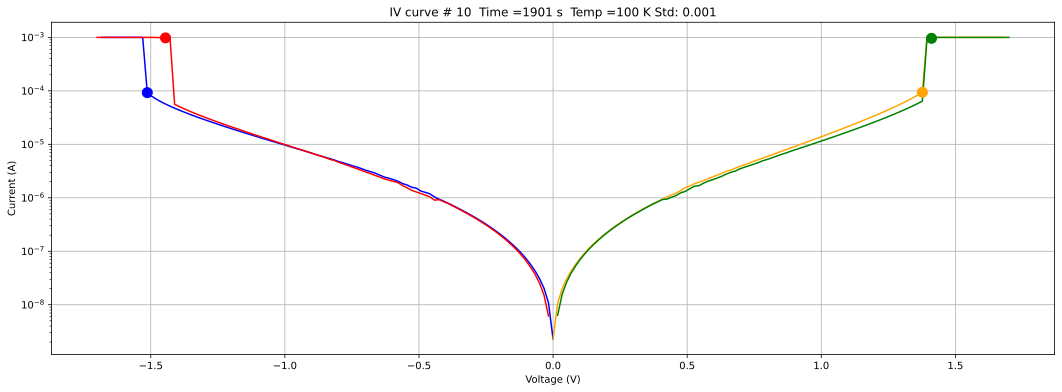

<Figure size 1800x600 with 0 Axes>

data to graph:  [[[99.99986200000005, 99.99989599999999, 99.99984200000004, 100.00009900000005, 99.99994799999999, 99.999895, 99.99989299999999, 99.99987199999998, 99.99987400000003, 99.999847, 99.99994000000002, 99.99986800000005, 100.00004499999999, 99.999979, 99.99998600000006, 99.99995500000003, 99.99989500000005, 100.00005900000004, 99.99985100000002, 100.00003900000007, 100.00003700000005, 99.99984199999999, 99.99988300000004, 99.99999600000007, 99.999879, 99.99993300000001, 99.99999099999997, 99.99997700000007, 100.00009600000003, 99.99973700000002, 99.99981399999999, 100.00005800000002, 100.00011700000003, 99.999973, 99.99988484848485, 100.00003600000004, 100.000022, 99.99995999999997, 100.00018600000003, 100.00005800000001, 100.00004200000005, 99.99984040404041, 100.00016300000009, 100.00027700000004, 100.00017500000006, 100.00004200000004, 100.00005300000001], [1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.

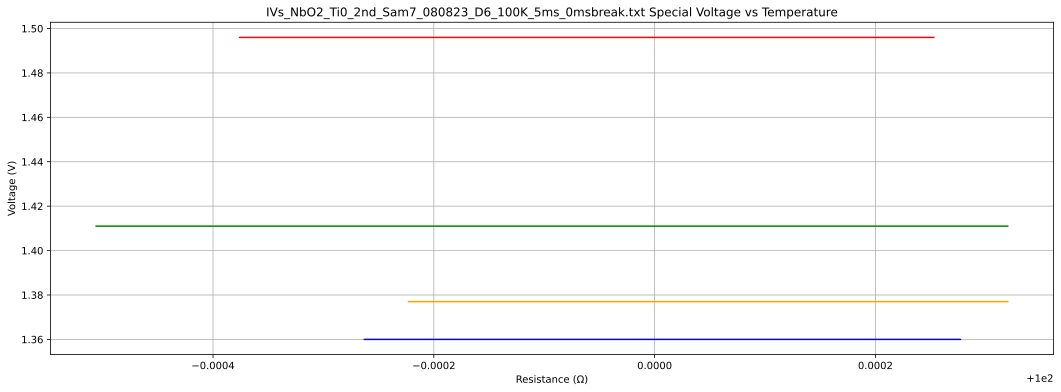

<Figure size 1800x600 with 0 Axes>

data to graph:  [[[16278.114458125508, 16316.529147919657, 16240.933290008257, 16302.833768155484, 16319.505192602563, 16328.467289997901, 16306.616181702708, 16337.003553298275, 16372.083526999433, 16326.76189170507, 16321.853509684563, 16319.076340279142, 16363.329441828784, 16406.055668159537, 16326.383615993855, 16374.011313719437, 16408.822927565667, 16340.774353250777, 16428.970072698194, 16360.042184849954, 16387.994444469885, 16334.99225589246, 16423.678742216718, 16363.473166430722, 16352.948574906666, 16390.793146864762, 16371.287314045952, 16352.109001234827, 16390.99661839277, 16410.565315015283, 16393.258850883183, 16418.093511666022, 16397.723899465556, 16420.194714532503, 16361.38645426379, 16368.583921308516, 16430.69490603757, 16423.694609127542, 16417.879457031755, 16432.791393567168, 16399.370987655737, 16425.237812684896, 16430.399137887292, 16458.718025612186, 16476.22293250358, 16444.104975780614, 16442.566176795066], [1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.36, 1.3

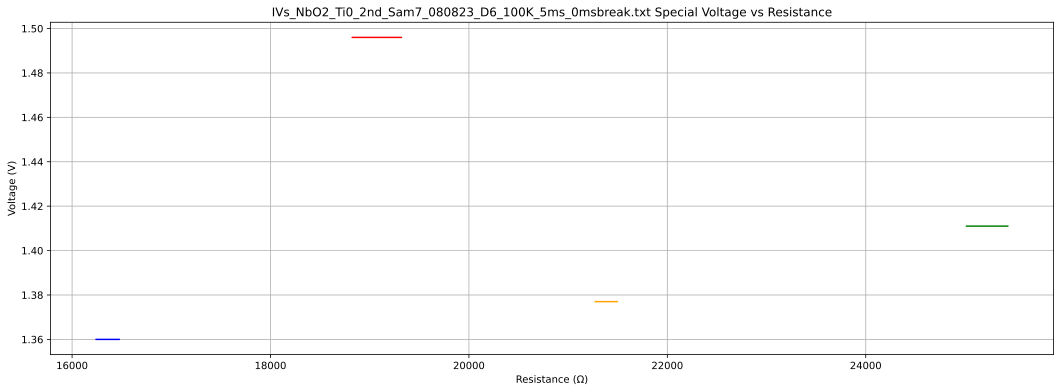

<Figure size 1800x600 with 0 Axes>

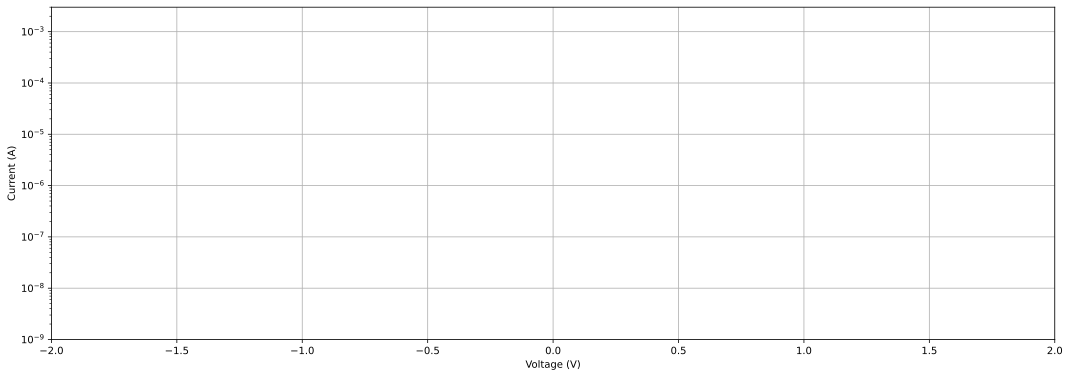

In [23]:
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");

# newest file: IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool
theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt");


theFile.graph_all_data()
theFile.graph_IV_curves(2)
theFile.graph_IV_curve(10)
theFile.graph_voltage_vs_temp_type("posThresh")
theFile.graph_voltage_vs_resistance()

# theFile.
# theFile.graph_resistance_vs_temp_123()
# theFile.graph_voltage_vs_temp_type("negThresh")
# theFile.graph_voltage_vs_temp_type("posHold")
# theFile.graph_voltage_vs_temp_type("negHold")
# # theFile.graph_voltage_vs_temp()
# # theFile.graph_resistance_vs_temp(0.2)
# # theFile.graph_resistance_vs_temp(0.3)

# for i in range(4, 6, 1):
#     index = i / 10
#     theFile.graph_resistance_vs_temp(index, "posThresh")
#     theFile.graph_resistance_vs_temp(index, "negThresh")
#     theFile.graph_resistance_vs_temp(index, "posHold")
#     theFile.graph_resistance_vs_temp(index, "negHold")

# theFile.graph_resistance_vs_temp(0.5)
# theFile.graph_resistance_vs_temp(0.6)
# theFile.graph_resistance_vs_temp(0.7)
# theFile.graph_resistance_vs_temp(0.8)
# theFile.graph_IV_curves_at_temp(84, 87)








# resistance as a function of temp as it cools. 4 graphs. 








fig, ax = plt.subplots()

# index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
# points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

line, = ax.semilogy(0.0000000001, 0.0000001)
# point = ax.plot(1, 1, marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
plt.xlim([-2, 2])
plt.ylim([0.000000001, 0.003])
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.grid()


def animate(i):

    x = []
    y = []
    
    normal_i = i
    i = i * (int)(len(theFile.IV_curves) / 100)

    print("progress ", i, "/", len(theFile.IV_curves))

    points_to_graph = []

    # print("range: ", len(theFile.IV_curves[0]['V'] - 1))
    for index in range(len(theFile.IV_curves[i]['V']) - 1):

        four_curves_x = [
            theFile.IV_curves[i + 0]['V'].tolist(),
            theFile.IV_curves[i + 1]['V'].tolist(),
            theFile.IV_curves[i + 2]['V'].tolist(),
            theFile.IV_curves[i + 3]['V'].tolist(),
            ]
        
        four_curves_y = [
            theFile.IV_curves[i + 0]['I'].tolist(),
            theFile.IV_curves[i + 1]['I'].tolist(),
            theFile.IV_curves[i + 2]['I'].tolist(),
            theFile.IV_curves[i + 3]['I'].tolist(),
            ]
        
        fine_tune = 0
        index_to_graph = [
            theFile.IV_curves[i + 0]['max_ddI'] + fine_tune,
            theFile.IV_curves[i + 1]['max_ddI'] + fine_tune,
            theFile.IV_curves[i + 2]['max_ddI'] + fine_tune,
            theFile.IV_curves[i + 3]['max_ddI'] + fine_tune,
            ]
        
        points_to_graph = [
            [theFile.IV_curves[i + 0]['V'][index_to_graph[0]], theFile.IV_curves[i + 0]['I'][index_to_graph[0]]],
            [theFile.IV_curves[i + 1]['V'][index_to_graph[1]], theFile.IV_curves[i + 1]['I'][index_to_graph[1]]],
            [theFile.IV_curves[i + 2]['V'][index_to_graph[2]], theFile.IV_curves[i + 2]['I'][index_to_graph[2]]],
            [theFile.IV_curves[i + 3]['V'][index_to_graph[3]], theFile.IV_curves[i + 3]['I'][index_to_graph[3]]],
        ]
        
        # voltage = self.IV_curves[index + i]['V']
        # current = self.IV_curves[index + i]['I']
        # data_to_graph.append([voltage, current])

        # fine_tune = 0
        # type_of_data = self.IV_curves[index + i]['type_of_data']
        # if type_of_data == "posThresh":
        #     fine_tune = 1
        # if type_of_data == "negThresh":
        #     fine_tune = 1
        # if type_of_data == "posHold":
        #     fine_tune = -2
        # if type_of_data == "negHold":
        #     fine_tune = -2
        
        # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
        # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])
        
        
        
        
        
        # print("V: ", four_curves_x)
        # print("sum: ", sum(four_curves_x, []))
        
        x.append(sum(four_curves_x, []))
        y.append(sum(four_curves_y, []))

        # print("type:", sum(x, []))



        # 'time': self.time[start:stop],
        # 'I': self.I[start:stop],
        # 'dI': dI,
        # 'ddI': ddI,
        # 'V': self.V[start:stop],
        # 'temps': self.temps[start:stop],
        # 'temp': run_temp,
        # 'temp_std': run_temp_std,
        # 'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
        # 'max_ddI': np.argmax(ddI),


        # print("points_to_graph: ", points_to_graph)
        # for point in points_to_graph:
        #     plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
    
    title_time = "  Time =" + str(round(theFile.IV_curves[i]['time'][0])) + " s"
    title_temp = "  Temp =" + str(round(theFile.IV_curves[i]['temp'])) + " K" + " Std: " + str(round(theFile.IV_curves[i]['temp_std'], 3))
    title = "IV curve # " + str(i) + title_time + title_temp + " " + theFile.file_name
    ax.set_title(title)
    line.set_xdata(sum(x, []))  # update the data.
    line.set_ydata(sum(y, []))  # update the data.
    return line,


# ani = animation.FuncAnimation(
#     fig, animate, interval=50, blit=True, save_count=100)
#                 # time between frames (ms)    number of frames
# ani.save(theFile.file_name[:-4] + ".gif")

# plt.show()




asdf

In [24]:
# four_curves_x = [
# theFile.IV_curves[5 + 0]['V'].tolist(),
# theFile.IV_curves[5 + 1]['V'].tolist(),
# theFile.IV_curves[5 + 2]['V'].tolist(),
# theFile.IV_curves[5 + 3]['V'].tolist(),
# ]
print(theFile.file_name)
# print(type([1, 2, 3]))

# ini_list = four_curves_x
 
# # printing initial list
# print ("initial list ", str(ini_list))
 
# # converting 2d list into 1d
# flatten_list = sum(ini_list, [])
 
# # printing flatten_list
# print ("final_result", str(flatten_list))



# put everything on one Graph
# color code everything

# v vs r
# make gif for all files






# behaves as expected:
# IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool
# IVs_NbO2_Ti0_Sam3_051823_D22_opened
# IVs_NbO2_Ti0_Sam3_051823_D22 - very messy at the end
# IVs_NbO2_Ti0_Sam3_052423_D15_cool - very good
# IVs_NbO2_Ti10_Sam3_042023_D18_try2 - kinda messy at the end



# IVs_NbO2_Ti10_Sam3_042723_D18 - does nothing





IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt
